In [1]:
import os
import warnings

import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd
import seaborn as sn
from sqlalchemy import text

plt.style.use("ggplot")
warnings.simplefilter("ignore")

In [5]:
eng = nivapy.da.connect_postgis()

Connection successful.


# Terrestrial fluxes

## Notebook 02: Estimate flows

 Using catchment boundaries derived in the previous notebook, daily simulated flow data are derived for each catchment using two methods:

 1. Area-scaling the vassdragsområde-level flow data provided each year by Stein Beldring for TEOTIL/Elveovervåkingsprogrammet, and
    
 2. Summing runoff data for upstream grid cells using parameter `gwb_q` from the [GTS API](https://api.nve.no/doc/gridtimeseries-data-gts/#introduksjon).

**Note:** The dataset from Stein uses a spatially-distributed version of HBV implemented in C++. These results are the most reliable, but they are delivered annually and are only available aggregated to vassdragsområde level. The GTS API provides similar output from a slightly different version of the model (implemented in Fortran). Stein recommends using output from the C++ version where possible, but the Fortran version runs operationally and results can be queried at 1 km resolution for any area, making it more flexible. The two approaches are compared at the end of this notebook.

## User input

In [15]:
# NVE flow series to use for data from Stein. Year of data supply
nve_data_year = 2024

# Period of interest for flow data
st_yr, end_yr = 2018, 2023

# Output time resolution for discharge series ('daily', 'monthly', 'annual').
# NVE's raw model output is daily. Monthly and annual series are calculated by averaging
t_res = "monthly"

# Folder to read/save output
# output_dir = "/home/jovyan/shared/common/JES/terrestrial_fluxes"
output_dir = "/home/jovyan/shared/common/catchment2coast/riv_fluxes"
cat_shp_name = "catchments_over_50km2.shp"
outlets_shp_name = "outlets_over_50km2.shp"

In [16]:
# Validate inputs
if t_res not in ["daily", "monthly", "annual"]:
    raise ValueError("'t_res' must be one of ['daily', 'monthly', 'annual'].")

# Frequency codes for resampling
resamp_dict = {"daily": "D", "monthly": "MS", "annual": "YS"}

# Read in catchment and outlet shapefiles
cat_gdf = gpd.read_file(os.path.join(output_dir, "shp", cat_shp_name))
outlet_gdf = gpd.read_file(os.path.join(output_dir, "shp", outlets_shp_name))

## Area-scaling from vassdragsområde data

Each year, Stein provides daily flow time series from 1990 to the present for each vassdragsområde. A simple way to estimate flows for each catchment of interest is therefore to area-scale the vassdragsområde-level data to match the target catchments. This will probably work OK for small coastal vassdragsområder comprising many small catchments. It should also work for the outflows of major rivers. However, it probably won't work well for small coastal catchments within larger vassdragsområder, because the vassdragsområde-level totals will not be representative of local runoff near to the coast.

In [11]:
# Get vassom properties
vassom_gdf = nivapy.da.read_postgis("physical", "norway_nve_vassdragomrade_poly", eng)

# Loop over catchments
df_list = []
for idx, row in cat_gdf.iterrows():
    elvid = row["elvid"]

    # Identify vassom for catchment
    vassdragnr_col = "nbfVassNr"  # "vassdragnr" or "nbfVassNr"
    vassom = row[vassdragnr_col].split(".")[0]

    # Get area scale factor
    cat_area_km2 = row["area_km2"]
    vassom_area_km2 = vassom_gdf.query("vassdragsomradenr == @vassom")[
        "arealland_km2"
    ].iloc[0]
    assert cat_area_km2 < vassom_area_km2
    area_fac = cat_area_km2 / vassom_area_km2

    # Get NVE data for vassom
    sql = text(
        "SELECT * FROM teotil3.nve_hbv_discharge "
        "WHERE data_supply_year = :nve_data_year "
        "AND vassom = :vassom"
    )
    q_df = pd.read_sql(
        sql, eng, params={"nve_data_year": nve_data_year, "vassom": vassom}
    )[["date", "flow_m3/s"]].query(f"'{st_yr}-01-01' <= date <= '{end_yr}-12-31'")

    # Scale flows
    q_df["flow_m3/s"] = area_fac * q_df["flow_m3/s"]

    # Resample to output frequency
    q_df = q_df.set_index("date").resample(resamp_dict[t_res]).mean().reset_index()

    q_df["elvid"] = elvid

    df_list.append(q_df)

q_df = pd.concat(df_list, axis="rows")
q_df = q_df[["elvid", "date", "flow_m3/s"]]

flow_csv_path = os.path.join(output_dir, "csv", "flows_scale_vassoms.csv")
q_df.to_csv(flow_csv_path, index=False)

q_df.head()

,elvid,date,flow_m3/s
0,2,2018-01-01,1.613591
1,2,2018-02-01,1.248788
2,2,2018-03-01,1.067233
3,2,2018-04-01,2.031468
4,2,2018-05-01,14.228752


## Data from GTS API

An alternative approach is to use the GTS API to download simulated daily runoff for all 1 km grid cells within each target catchment. Summing the runoff gives an estimate of the outlet discharge.

Note: this takes a long time! TODO: add tracker/counter

In [17]:
%%capture
# Loop over catchments of interest. GTS API occasionally times-out, so the code
# below includes a hacky solution to retry up to 'n_retries' times when this occurs.
# TO DO: Update nivapy.da.get_nve_gts_api_aggregated_time_series to properly handle
# timeout errors, then streamline this code.
n_retries = 10
df_list = []
for idx in range(len(cat_gdf)):
    retry_count = 0
    while retry_count < n_retries:
        try:
            gwb_df = nivapy.da.get_nve_gts_api_aggregated_time_series(
                cat_gdf.iloc[[idx]],
                ["gwb_q"],
                f"{st_yr}-01-01",
                f"{end_yr}-12-31",
                id_col="elvid",
            )
            break
        except ValueError:
            # No data for catchment. Move to next iteration
            gwb_df = None
            break
        except Exception as e:
            # Probably a TimeoutError. Retry
            retry_count += 1
            if retry_count >= n_retries:
                gwb_df = None
                break

    if gwb_df is None:
        continue

    cat_area = cat_gdf["area_km2"].iloc[idx]
    gwb_df["flow_m3/s"] = 1e6 * gwb_df["value_mean"] * cat_area / (1000 * 60 * 60 * 24)
    gwb_df = gwb_df[["elvid", "datetime", "flow_m3/s"]]
    gwb_df.columns = ["elvid", "date", "flow_m3/s"]

    # Resample to output frequency
    numeric_cols = gwb_df.select_dtypes(include=['number']).columns
    resampled_gwb_df = gwb_df.set_index("date")[numeric_cols].resample(resamp_dict[t_res]).mean().reset_index()
    resampled_gwb_df['elvid'] = gwb_df['elvid'][0]
    # gwb_df = gwb_df.set_index("date").resample(resamp_dict[t_res]).mean().reset_index()
    resampled_gwb_df = resampled_gwb_df[["elvid", "date", "flow_m3/s"]]

    df_list.append(resampled_gwb_df)

gwb_df = pd.concat(df_list, axis="rows")

# Save
flow_csv_path = os.path.join(output_dir, "csv", "flows_gts-api.csv")
gwb_df.to_csv(flow_csv_path, index=False)

gwb_df.head()

## Combine datasets

In [19]:
# Combine datasets
df = pd.merge(
    q_df,
    gwb_df,
    how="inner",
    on=["elvid", "date"],
    suffixes=["_scale-vassoms", "_gts-api"],
)

df = df.rename({'flow_m3/s_scale-vassoms': 'q_scale-vassoms',
                'flow_m3/s_gts-api': 'q_gts-api'}, axis=1)

# Add col which is mean of two methods
df['q_sim-mean'] = df[['q_scale-vassoms', 'q_gts-api']].mean(axis=1)

# Save
flow_csv_path = os.path.join(output_dir, "csv", "q_sim_both_methods.csv")
df.to_csv(flow_csv_path, index=False)

df

,elvid,date,q_scale-vassoms,q_gts-api,q_sim-mean
0,2,2018-01-01,1.613591,0.767192,1.190391
1,2,2018-02-01,1.248788,0.767618,1.008203
2,2,2018-03-01,1.067233,0.433712,0.750473
3,2,2018-04-01,2.031468,0.399219,1.215343
4,2,2018-05-01,14.228752,16.028459,15.128605
...,...,...,...,...,...
8419,873,2023-08-01,0.843937,1.140566,0.992251
8420,873,2023-09-01,0.777196,0.781822,0.779509
8421,873,2023-10-01,1.292026,1.509840,1.400933
8422,873,2023-11-01,0.691505,0.679889,0.685697


## Quick plots

Compare flows estimated using the two methods.

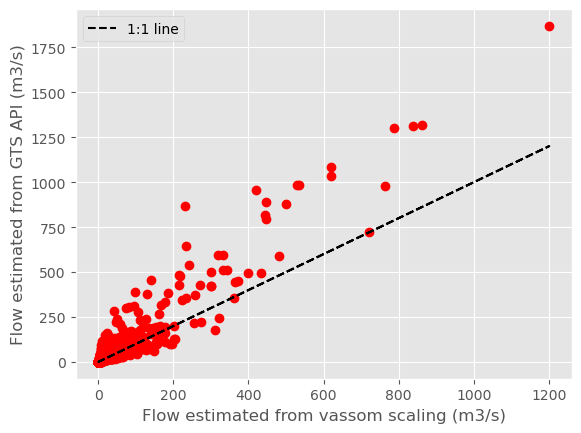

In [20]:
plt.plot(df["q_scale-vassoms"], df["q_gts-api"], "ro")
plt.plot(
    df["q_scale-vassoms"],
    df["q_scale-vassoms"],
    "k--",
    label="1:1 line",
)
plt.xlabel("Flow estimated from vassom scaling (m3/s)")
plt.ylabel("Flow estimated from GTS API (m3/s)")
plt.legend(loc="upper left")

The code above estimates flows for potentially hundreds of catchments. The cell below picks `n_plot` catchments from these at random and shows flow time series for comparison.

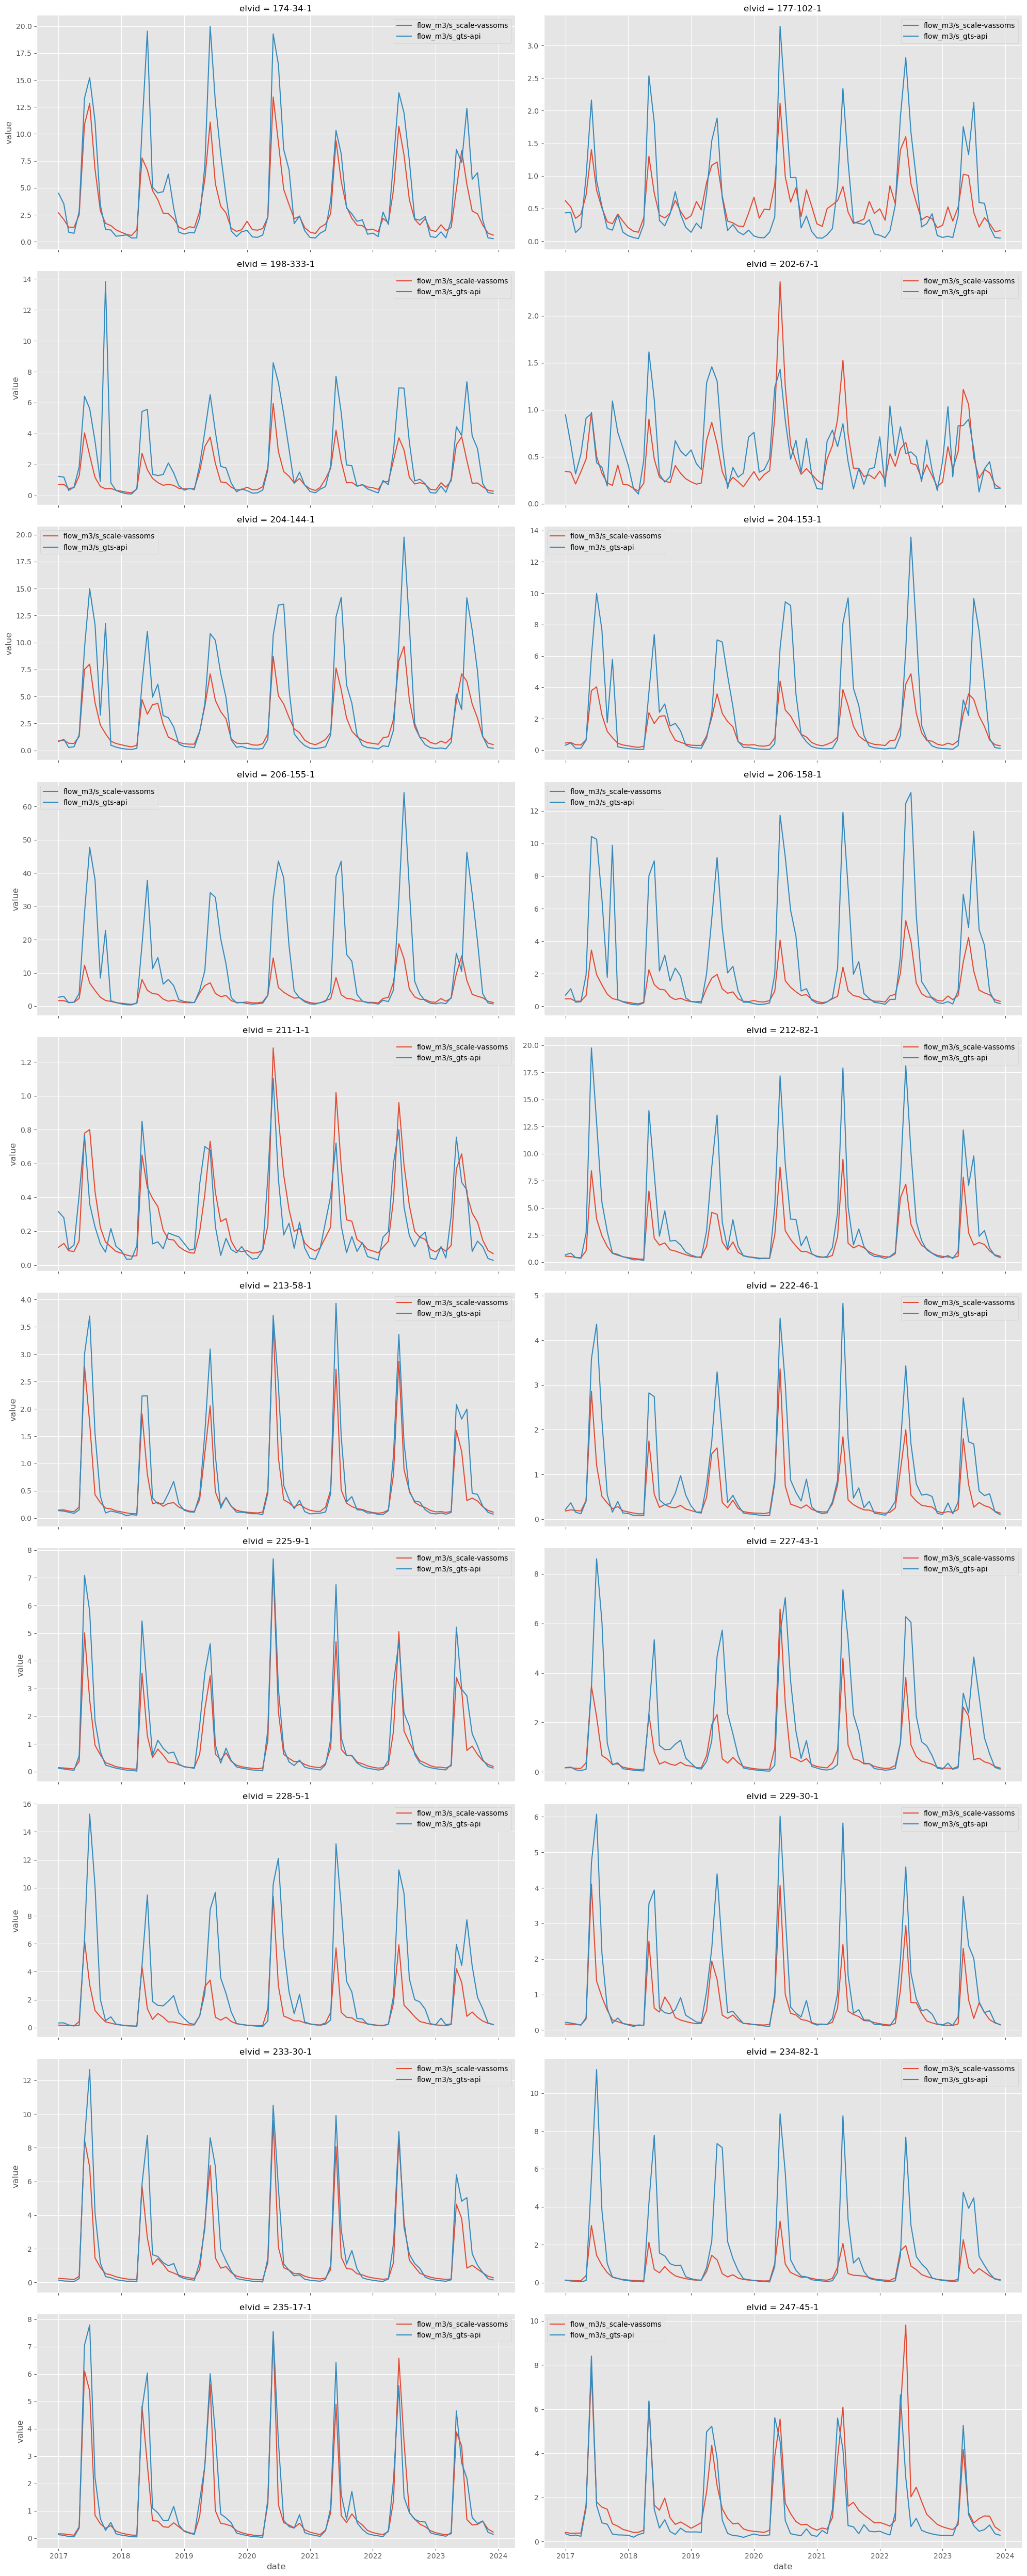

In [39]:
# Select n_plot sites at random for visualisation
n_plot = 20
df_long = df.melt(id_vars=["elvid", "date"], var_name="par")
elvids = df_long["elvid"].drop_duplicates().sample(n=n_plot, random_state=1)
df_filtered = df_long[df_long["elvid"].isin(elvids)]

# Plot
g = sn.relplot(
    data=df_filtered,
    x="date",
    y="value",
    hue="par",
    col="elvid",
    col_wrap=2,
    kind="line",
    facet_kws={"sharey": False, "sharex": True, "legend_out": False},
    aspect=2,
)

handles, labels = g.axes.flat[0].get_legend_handles_labels()
for ax in g.axes.flat:
    ax.legend(handles, labels)